In [16]:
import csv
import numpy as np
from datetime import datetime

In [32]:
from pandas import read_csv
from pandas import datetime as p_datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [19]:
%matplotlib inline  

# Constants

In [16]:
STATION_ID_COL_NAME = 'station id'
STATION_NAME_COL_NAME = 'station name'
PARAM_T = 'T [°C]'
PARAM_RAIN = 'količina padavin [mm]'

# Initial Configuration

# Utils

In [4]:
def ARSO_datetime_to_epoch(datetime_string):
    """Convert ARSO datetime into epoch time in seconds"""
    utc_time = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time


def ARSO_datetime_to_epoch_array(datetime_strings):
    """Convert list of ARSO datetimes into epoch time in seconds"""
    return [ARSO_datetime_to_epoch(dt) for dt in datetime_strings]


def borzen_datetime_to_epoch(datetime_string):
    """Convert borzen datetime into epoch time in seconds"""
    try:
        utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
    except:
        # strptime accepts [0,23] hour interval, while borzen data has [1,24] hour 
        # interval, thus modification of '24' into '00' is needed
        if datetime_string[-2:] == "24":
            datetime_string = datetime_string[:-2] + "00"
            utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
        else:
            print("Error in datetime parsing: " + datetime_string)
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

# Library

In [5]:
class Station:
    def __init__(self, station_id, station_name, header, data, data_timestamp_epoch):
        self.station_is = station_id
        self.station_name = station_name
        self.header = header
        self.data = data
        self.size = len(data)
        self.data_ts = data_timestamp_epoch
    
    def __str__(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)
    
    def __repr(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)

In [6]:
class Prices:
    def __init__(self, prices, prices_timestamp_epoch):
        self.prices = prices
        self.timestamps = prices_timestamp_epoch

In [7]:
def test_load_ksedlo():
    """Load weather data for Korenjsko sedlo that has been dowloaded 
    from ARSO website. It removes lines that have any NaN values."""
    print('Start loading korenjsko sedlo')
    import csv
    test_file_ksedlo = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/WeatherDataTest/KorenjskoSedloTest'
    # open file and read content in a csv format
    csvfile = open(test_file_ksedlo, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [8]:
def test_load_borzen_price():
    """Load borzen power prices."""
    print("Load test borzen prices.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    timestamps = []
    prices = []
    for line in data_clean:
        timestamps.append(borzen_datetime_to_epoch(line[0]))
        prices.append(float(line[1].strip().replace(",",".")))
    # convert list into numpy array
    timestamps = np.array(timestamps)
    prices = np.array(prices)
    # finish
    print("Loading test borzen prices successful!")
    # TODO 
    return Prices(prices, timestamps)

# Load Data

In [9]:
# Load training data ksedlo and power prices
ksedlo_station = test_load_ksedlo()
#consumption = DataLoader.test_load_borzen_consumption()

Start loading korenjsko sedlo
Loading successful


In [10]:
# Check data and remove unnecessary columns
ksedlo_station.data
ksedlo_station.size

1440

# ARIMA 

The example of using ARIMA model in python is described here:
http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [11]:
# Load price data
prices = test_load_borzen_price()

Load test borzen prices.
Loading test borzen prices successful!


In [40]:
# generate pandas dataframe with prices and datetimes
d = {'price': prices.prices}
dt = pandas.to_datetime(prices.timestamps, unit = "s")
series = pandas.DataFrame(data=d, index = dt)
series.head()

,price
2017-01-01 01:00:00,53.00
2017-01-01 02:00:00,52.00
2017-01-01 03:00:00,51.00
2017-01-01 04:00:00,47.27
2017-01-01 05:00:00,45.49


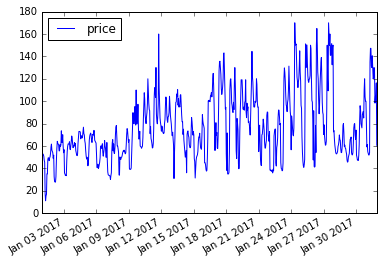

In [41]:
# plot timeseries
series.plot()

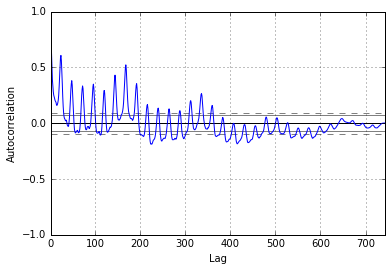

In [42]:
# plot autocorrelation
autocorrelation_plot(series)

In [49]:
# fit ARIMA model and display summary
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  743
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2982.976
Method:                       css-mle   S.D. of innovations             13.405
Date:                Thu, 06 Apr 2017   AIC                           5979.953
Time:                        14:19:23   BIC                           6012.228
Sample:                    01-01-2017   HQIC                          5992.395
                         - 01-31-2017                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0311      0.405      0.077      0.939        -0.763     0.825
ar.L1.D.price     0.0710      0.036      1.981      0.048         0.001     0.141
ar.L2.D.price    -0.0043      0.036     

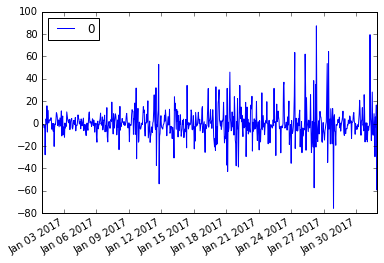

In [52]:
# residuals
residuals = pandas.DataFrame(model_fit.resid)
residuals.plot()

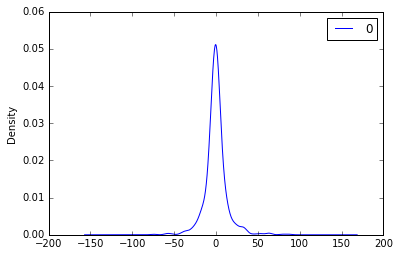

In [53]:
residuals.plot(kind='kde')

In [73]:
n = 20
fc_group = model_fit.forecast(n)
print(fc_group)

(array([ 59.2752569 ,  59.800184  ,  71.55657486,  72.72604068,
        72.87519344,  72.78227915,  71.92480735,  69.36549643,
        68.97147561,  68.97346667,  69.10738805,  69.5044324 ,
        70.13089535,  70.29274573,  70.32720926,  70.30812987,
        70.21914793,  70.10879649,  70.10313667,  70.13566684]), array([ 13.40542159,  19.64302504,  24.33664132,  28.2096826 ,
        31.21939184,  32.92029473,  34.41771667,  35.85129105,
        37.25746556,  38.71630645,  40.30208349,  41.86264454,
        43.36650775,  44.80671483,  46.17062334,  47.45885318,
        48.70466543,  49.92002882,  51.11099398,  52.28305325]), array([[  33.00111339,   85.5494004 ],
       [  21.30056238,   98.29980562],
       [  23.85763438,  119.25551534],
       [  17.43607877,  128.0160026 ],
       [  11.68630982,  134.06407706],
       [   8.25968712,  137.30487118],
       [   4.46732224,  139.38229245],
       [  -0.90174282,  139.63273568],
       [  -4.05181505,  141.99476627],
       [  -6.9

In [74]:
# forecast; returns array of forecasts, array of standard error and array of 95% confidence interval
fc = fc_group[0]
se = fc_group[1]
ci = fc_group[2]

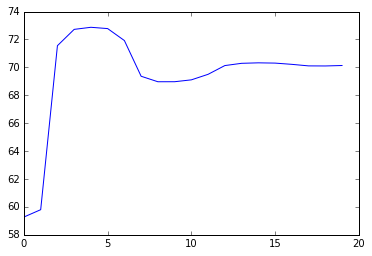

In [75]:
pyplot.plot(fc)